# A notebook for calculating recurrence interval

_This notebook was created by Neta Wechsler._

Recurrence interval between earthquake C14 dates, based on random sample generation from discrete distributions with the Alias method

This notebook uses the dates text files generated by OxCal, and assumes tab separation.

The files in the example are from Wechsler et al. 2018[1]

### **The file names must correspond to their chronological order and be ordered from the latest event to the most early event.**

[1] Wechsler, N., Rockwell, T. K., Klinger, Y., 2018, Variable Slip-Rate and Slip-Per-Event on a Plate Boundary Fault: The Dead Sea Fault in northern Israel, Tectonophysics, Vol. 722, pp. 210-226. DOI 10.1016/j.tecto.2017.10.017

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import sys
from alias import *

If the file names are in __increasing__ chronological order, please change the `REVERSE` flag to `False`

In [19]:
# set path to folder containing distribution text files
path = "../files/"

# If the file names, when alphabetically sorted, are in _increasing_ chronological order -  
# change this flag to False
REVERSE = True
if os.path.isdir(path):
    files = [path+f for f in os.listdir(path) if f.endswith('.prior')]
print("The list of files to process is:", *sorted(files, reverse=REVERSE), sep="\n")
print("MAke sure they are ordered by name from early to late")

The list of files to process is:
../files/4_E6.prior
../files/4_E5.prior
../files/4_E4.prior
../files/4_E3.prior
../files/4_E2.prior
../files/4_E1.prior
../files/3_E2.prior
../files/3_E1.prior
../files/2_E1.prior
../files/1_1202.prior
../files/0_1759.prior
MAke sure they are ordered by name from early to late


The file names should correspond to the earthquake events, so that when they are sorted alphabetically they are in the correct chronological order.

In [4]:
# parse the text files
def parse_file(fn):
    """ read years and probabilities from a file """
    years = []
    probs = []
    with open(fn, 'r') as fp:
        line = fp.readline()
        while line:
            year, prob = list(map(float, line.split("\t")))
            if prob > 0:
                years.append(int(year))
                probs.append(prob)
            line = fp.readline()
    return years, probs        

OxCal produces discrete probability density functions for an earthqake date with year interval every 5 years. It is possible to convert it to a pdf with value for every year using the following function:

In [28]:
def increase_resolution(years, probs):
    """ a function for converting a pdf to be yearly """
    assert len(years) == len(probs), "Arrays should have the same length"
    if len(years) < 2:
        return years, probs
    nyears = []
    nprobs = []
    for i in range(len(years)-1):
        dy = years[i+1] - years[i]
        if dy < 2:
            nyears.append(years[i+1])
            nprobs.append(probs[i+1])
        else:
            dp = probs[i+1] - probs[i]
            for j in range(dy):
                nyears.append(years[i]+j)
                nprobs.append(probs[i] + dp/dy*j)
    # finally, normalize the probabilities
    norm = 1./sum(nprobs)
    return nyears, [p*norm for p in nprobs]

This function calculates the year intervals and makes sure the interval is larger than the threshold, so that if a sequence [660, 740, 737, 812] appears, it is considered an illegal sequence (negative difference between earthquake dates) and an empty list is returned.

In [6]:
def recurrence(years, thresh):
    """ function for calculating recurrence interval from a list of years """
    diffs = np.array([years[i+1] - years[i] for i in range(len(years) - 1)])
    if np.any(diffs < thresh):  # there is one interval that is smaller than the threshold
        return []
    return diffs

Here it is possible to control the minimum allowed interval between earthquakes, the number of samples for the random drawing, and the subsampling of the distribution to 1 year intervals.

In [50]:
# global parameter tuning
YEARLY = True  # change to false if resolution increase is unwanted
MIN_RECURRENCE = 5  # the minimum interval allowed between consecutive earthquake, in years
NUM_SAMPLES = 10000  # number of random samples to generate for recurrence interval calculations

Main loop - read the files and create random samples of recurrence interval arrays

parsing ../files/4_E6.prior
parsing ../files/4_E5.prior
parsing ../files/4_E4.prior
parsing ../files/4_E3.prior
parsing ../files/4_E2.prior
parsing ../files/4_E1.prior
parsing ../files/3_E2.prior
parsing ../files/3_E1.prior
parsing ../files/2_E1.prior
parsing ../files/1_1202.prior
parsing ../files/0_1759.prior


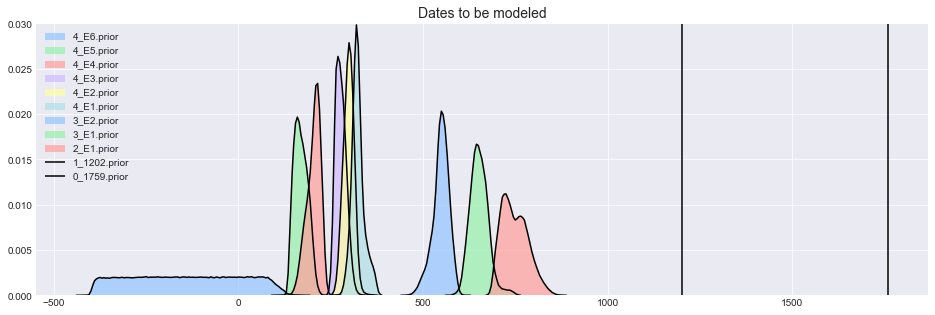

In [78]:
aliases = []
plt.figure(figsize=(16, 5))
# create an array of alias tables
for f in sorted(files, reverse=REVERSE):
    print("parsing", f)
    years, probs = parse_file(f)
    if not np.isclose(np.sum(probs), 1):
        norm = 1./np.sum(probs)
        probs = [p*norm for p in probs]
    if YEARLY:
        years, probs = increase_resolution(years, probs)
    alias = C14Date(probs, years)
    aliases.append(alias)
    if len(years) >  1:
        plt.plot(years, probs, c='k')
        plt.fill_between(years, 0, probs, label=f.split('/')[-1], alpha=0.7)
    else:
        # plot known dates with probability 1
        plt.vlines(years, 0, 0.05, label=f.split('/')[-1])
plt.ylim((0, 0.03))
plt.title("Dates to be modeled", size=14)
plt.legend(loc='upper left');
# for saving the figure, uncomment the wanted format
# plt.savefig(fname=path+'probabilities.png', dpi=300, format='png');
# plt.savefig(fname=path+'probabilities.eps', format='eps');

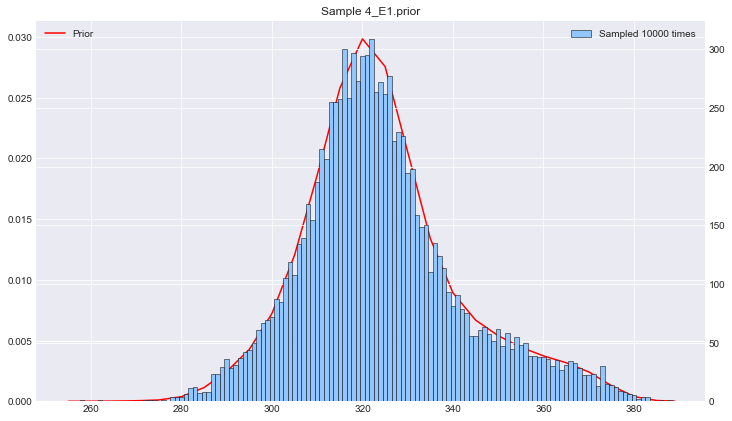

In [72]:
# sanity check - plot the samples and the original distribution of one random date
ind = np.random.randint(len(aliases))
years = aliases[ind].years
probs = aliases[ind].dist
sampled = aliases[ind].sample_years(NUM_SAMPLES)
nbins = len(years)
name = files[ind].split('/')[-1]

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(years, probs, '-r', label="Prior")
ax1.set_ylim([0,max(probs)*1.05])
plt.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.hist(sampled, bins=years, align='left', edgecolor="k", linewidth=0.5, label=f"Sampled {NUM_SAMPLES} times")
ax = plt.gca()
plt.xlabel("years")
plt.title("Sample %s" % name)
plt.legend();

In [51]:
recur = []
c = 0
while len(recur) < NUM_SAMPLES:
    years = [a.sample_years()[0] for a in aliases]  # sample all the distributions
    diffs = recurrence(years, MIN_RECURRENCE)
    if len(diffs) > 0:
        recur.append(diffs)
    else:
        c += 1
recur = np.array(recur)
if c > NUM_SAMPLES:
    print("With threshold %d had to resample %d times, \
    check if file order is correct (increasing)" % (MIN_RECURRENCE, c))

We can now use those samples to calculate mean recurrence interval and coefficient of variation for the recurrence interval.

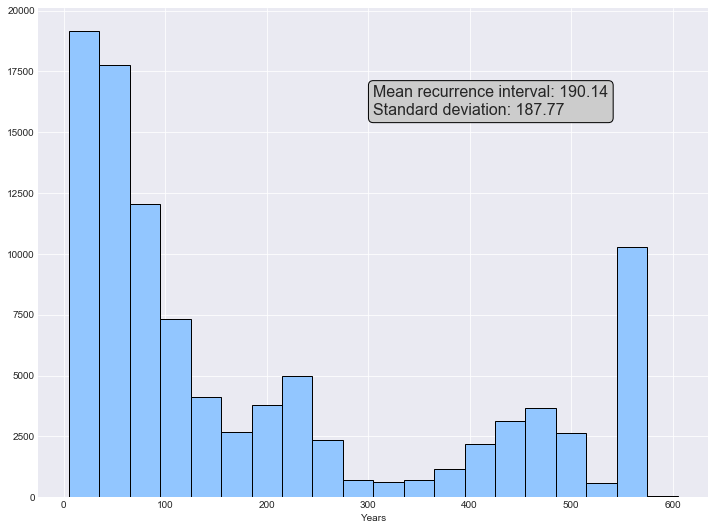

In [101]:
plt.figure(figsize=(12,9))
plt.hist(recur.ravel(), bins=20, edgecolor="k")
plt.xlabel("Years")
ax = plt.gca()
ax.annotate("Mean recurrence interval: %.2f\nStandard deviation: %.2f" % (np.mean(recur), np.std(recur)),
            xy=(0.5, 0.7), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));
# for saving the figure, uncomment the wanted format
# plt.savefig(fname=path+'sampled_recurrence.png', dpi=300, format='png');
# plt.savefig(fname=path+'sampled_recurrence.eps', format='eps');

## Coefficient of Variation

The coefficient of variation is calculated thus:
$$
CV = \frac{\sigma}{\mu}
$$

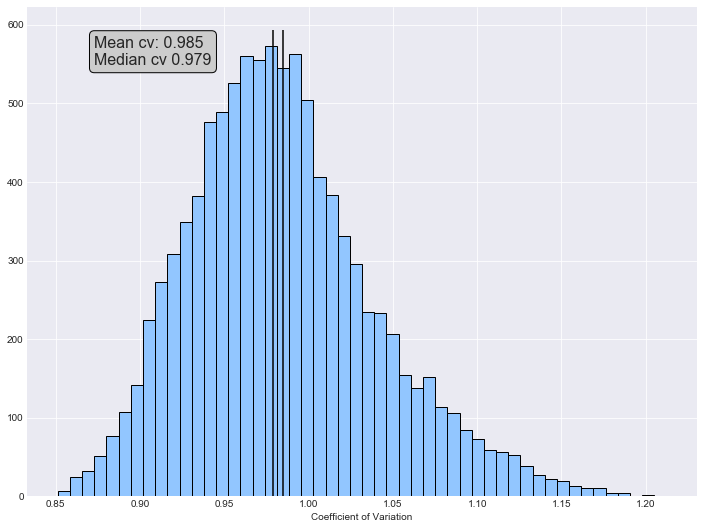

In [98]:
cv = np.std(recur, axis=1) / np.mean(recur, axis=1)
plt.figure(figsize=(12,9))
n, _, _ = plt.hist(cv, bins=50, edgecolor="k")
plt.vlines([np.mean(cv), np.median(cv)], 0, max(n)+20)
plt.xlabel("Coefficient of Variation")
ax = plt.gca()
ax.annotate("Mean cv: %.3f\nMedian cv %.3f" % (np.mean(cv), np.median(cv)),
            xy=(0.1, 0.8), xycoords='axes fraction', size=16,
            xytext=(0, 40), textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.8"));
# for saving the figure, uncomment the wanted format
# plt.savefig(fname=path+'cv.png', dpi=300, format='png');
# plt.savefig(fname=path+'cv.eps', format='eps');